In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr


In [1]:
import functools

import numpy as np
from scipy.ndimage import uniform_filter

from skimage._shared import utils
from skimage._shared.filters import gaussian
from skimage._shared.utils import _supported_float_type, check_shape_equality, warn
from skimage.util.arraycrop import crop
from skimage.util.dtype import dtype_range

def structural_similarity(
    im1,
    im2,
    *,
    win_size=None,
    gradient=False,
    data_range=None,
    channel_axis=None,
    gaussian_weights=False,
    full=False,
    **kwargs,
):
    """
    Compute the mean structural similarity index between two images.
    Please pay attention to the `data_range` parameter with floating-point images.

    Parameters
    ----------
    im1, im2 : ndarray
        Images. Any dimensionality with same shape.
    win_size : int or None, optional
        The side-length of the sliding window used in comparison. Must be an
        odd value. If `gaussian_weights` is True, this is ignored and the
        window size will depend on `sigma`.
    gradient : bool, optional
        If True, also return the gradient with respect to im2.
    data_range : float, optional
        The data range of the input image (difference between maximum and
        minimum possible values). By default, this is estimated from the image
        data type. This estimate may be wrong for floating-point image data.
        Therefore it is recommended to always pass this scalar value explicitly
        (see note below).
    channel_axis : int or None, optional
        If None, the image is assumed to be a grayscale (single channel) image.
        Otherwise, this parameter indicates which axis of the array corresponds
        to channels.

        .. versionadded:: 0.19
           ``channel_axis`` was added in 0.19.
    gaussian_weights : bool, optional
        If True, each patch has its mean and variance spatially weighted by a
        normalized Gaussian kernel of width sigma=1.5.
    full : bool, optional
        If True, also return the full structural similarity image.

    Other Parameters
    ----------------
    use_sample_covariance : bool
        If True, normalize covariances by N-1 rather than, N where N is the
        number of pixels within the sliding window.
    K1 : float
        Algorithm parameter, K1 (small constant, see [1]_).
    K2 : float
        Algorithm parameter, K2 (small constant, see [1]_).
    sigma : float
        Standard deviation for the Gaussian when `gaussian_weights` is True.

    Returns
    -------
    mssim : float
        The mean structural similarity index over the image.
    grad : ndarray
        The gradient of the structural similarity between im1 and im2 [2]_.
        This is only returned if `gradient` is set to True.
    S : ndarray
        The full SSIM image.  This is only returned if `full` is set to True.

    Notes
    -----
    If `data_range` is not specified, the range is automatically guessed
    based on the image data type. However for floating-point image data, this
    estimate yields a result double the value of the desired range, as the
    `dtype_range` in `skimage.util.dtype.py` has defined intervals from -1 to
    +1. This yields an estimate of 2, instead of 1, which is most often
    required when working with image data (as negative light intensities are
    nonsensical). In case of working with YCbCr-like color data, note that
    these ranges are different per channel (Cb and Cr have double the range
    of Y), so one cannot calculate a channel-averaged SSIM with a single call
    to this function, as identical ranges are assumed for each channel.

    To match the implementation of Wang et al. [1]_, set `gaussian_weights`
    to True, `sigma` to 1.5, `use_sample_covariance` to False, and
    specify the `data_range` argument.

    .. versionchanged:: 0.16
        This function was renamed from ``skimage.measure.compare_ssim`` to
        ``skimage.metrics.structural_similarity``.

    References
    ----------
    .. [1] Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P.
       (2004). Image quality assessment: From error visibility to
       structural similarity. IEEE Transactions on Image Processing,
       13, 600-612.
       https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf,
       :DOI:`10.1109/TIP.2003.819861`

    .. [2] Avanaki, A. N. (2009). Exact global histogram specification
       optimized for structural similarity. Optical Review, 16, 613-621.
       :arxiv:`0901.0065`
       :DOI:`10.1007/s10043-009-0119-z`

    """
    check_shape_equality(im1, im2)
    float_type = _supported_float_type(im1.dtype)

    if channel_axis is not None:
        # loop over channels
        args = dict(
            win_size=win_size,
            gradient=gradient,
            data_range=data_range,
            channel_axis=None,
            gaussian_weights=gaussian_weights,
            full=full,
        )
        args.update(kwargs)
        nch = im1.shape[channel_axis]
        mssim = np.empty(nch, dtype=float_type)

        if gradient:
            G = np.empty(im1.shape, dtype=float_type)
        if full:
            S = np.empty(im1.shape, dtype=float_type)
        channel_axis = channel_axis % im1.ndim
        _at = functools.partial(utils.slice_at_axis, axis=channel_axis)
        for ch in range(nch):
            ch_result = structural_similarity(im1[_at(ch)], im2[_at(ch)], **args)
            if gradient and full:
                mssim[ch], G[_at(ch)], S[_at(ch)] = ch_result
            elif gradient:
                mssim[ch], G[_at(ch)] = ch_result
            elif full:
                mssim[ch], S[_at(ch)] = ch_result
            else:
                mssim[ch] = ch_result
        mssim = mssim.mean()
        if gradient and full:
            return mssim, G, S
        elif gradient:
            return mssim, G
        elif full:
            return mssim, S
        else:
            return mssim

    K1 = kwargs.pop('K1', 0.01)
    K2 = kwargs.pop('K2', 0.03)
    sigma = kwargs.pop('sigma', 1.5)
    if K1 < 0:
        raise ValueError("K1 must be positive")
    if K2 < 0:
        raise ValueError("K2 must be positive")
    if sigma < 0:
        raise ValueError("sigma must be positive")
    use_sample_covariance = kwargs.pop('use_sample_covariance', True)

    if gaussian_weights:
        # Set to give an 11-tap filter with the default sigma of 1.5 to match
        # Wang et. al. 2004.
        truncate = 3.5

    if win_size is None:
        if gaussian_weights:
            # set win_size used by crop to match the filter size
            r = int(truncate * sigma + 0.5)  # radius as in ndimage
            win_size = 2 * r + 1
        else:
            win_size = 7  # backwards compatibility

    if np.any((np.asarray(im1.shape) - win_size) < 0):
        raise ValueError(
            'win_size exceeds image extent. '
            'Either ensure that your images are '
            'at least 7x7; or pass win_size explicitly '
            'in the function call, with an odd value '
            'less than or equal to the smaller side of your '
            'images. If your images are multichannel '
            '(with color channels), set channel_axis to '
            'the axis number corresponding to the channels.'
        )

    if not (win_size % 2 == 1):
        raise ValueError('Window size must be odd.')

    if data_range is None:
        if np.issubdtype(im1.dtype, np.floating) or np.issubdtype(
            im2.dtype, np.floating
        ):
            raise ValueError(
                'Since image dtype is floating point, you must specify '
                'the data_range parameter. Please read the documentation '
                'carefully (including the note). It is recommended that '
                'you always specify the data_range anyway.'
            )
        if im1.dtype != im2.dtype:
            warn(
                "Inputs have mismatched dtypes. Setting data_range based on im1.dtype.",
                stacklevel=2,
            )
        dmin, dmax = dtype_range[im1.dtype.type]
        data_range = dmax - dmin
        if np.issubdtype(im1.dtype, np.integer) and (im1.dtype != np.uint8):
            warn(
                "Setting data_range based on im1.dtype. "
                + f"data_range = {data_range:.0f}. "
                + "Please specify data_range explicitly to avoid mistakes.",
                stacklevel=2,
            )

    ndim = im1.ndim

    if gaussian_weights:
        filter_func = gaussian
        filter_args = {'sigma': sigma, 'truncate': truncate, 'mode': 'reflect'}
    else:
        filter_func = uniform_filter
        filter_args = {'size': win_size}

    # ndimage filters need floating point data
    im1 = im1.astype(float_type, copy=False)
    im2 = im2.astype(float_type, copy=False)

    NP = win_size**ndim

    # filter has already normalized by NP
    if use_sample_covariance:
        cov_norm = NP / (NP - 1)  # sample covariance
    else:
        cov_norm = 1.0  # population covariance to match Wang et. al. 2004

    # compute (weighted) means
    ux = filter_func(im1, **filter_args)
    uy = filter_func(im2, **filter_args)

    # compute (weighted) variances and covariances
    uxx = filter_func(im1 * im1, **filter_args)  # filtered squared values of image 1
    uyy = filter_func(im2 * im2, **filter_args)  # filtered squared values of image 2
    uxy = filter_func(im1 * im2, **filter_args)  # filtered product of images 1 and 2
    vx = cov_norm * (uxx - ux * ux)  # normalized variance of image 1
    vy = cov_norm * (uyy - uy * uy)  # normalized variance of image 2
    vxy = cov_norm * (uxy - ux * uy)  # normalized covariance between images 1 and 2

    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2

    A1, A2, B1, B2 = (
        2 * ux * uy + C1,
        2 * vxy + C2,
        ux**2 + uy**2 + C1,
        vx + vy + C2,
    )
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim. Use float64 for accuracy.
    mssim = crop(S, pad).mean(dtype=np.float64)

    if gradient:
        # The following is Eqs. 7-8 of Avanaki 2009.
        grad = filter_func(A1 / D, **filter_args) * im1
        grad += filter_func(-S / B2, **filter_args) * im2
        grad += filter_func((ux * (A2 - A1) - uy * (B2 - B1) * S) / D, **filter_args)
        grad *= 2 / im1.size

        if full:
            return mssim, grad, S
        else:
            return mssim, grad
    else:
        if full:
            return mssim, S
        else:
            return mssim


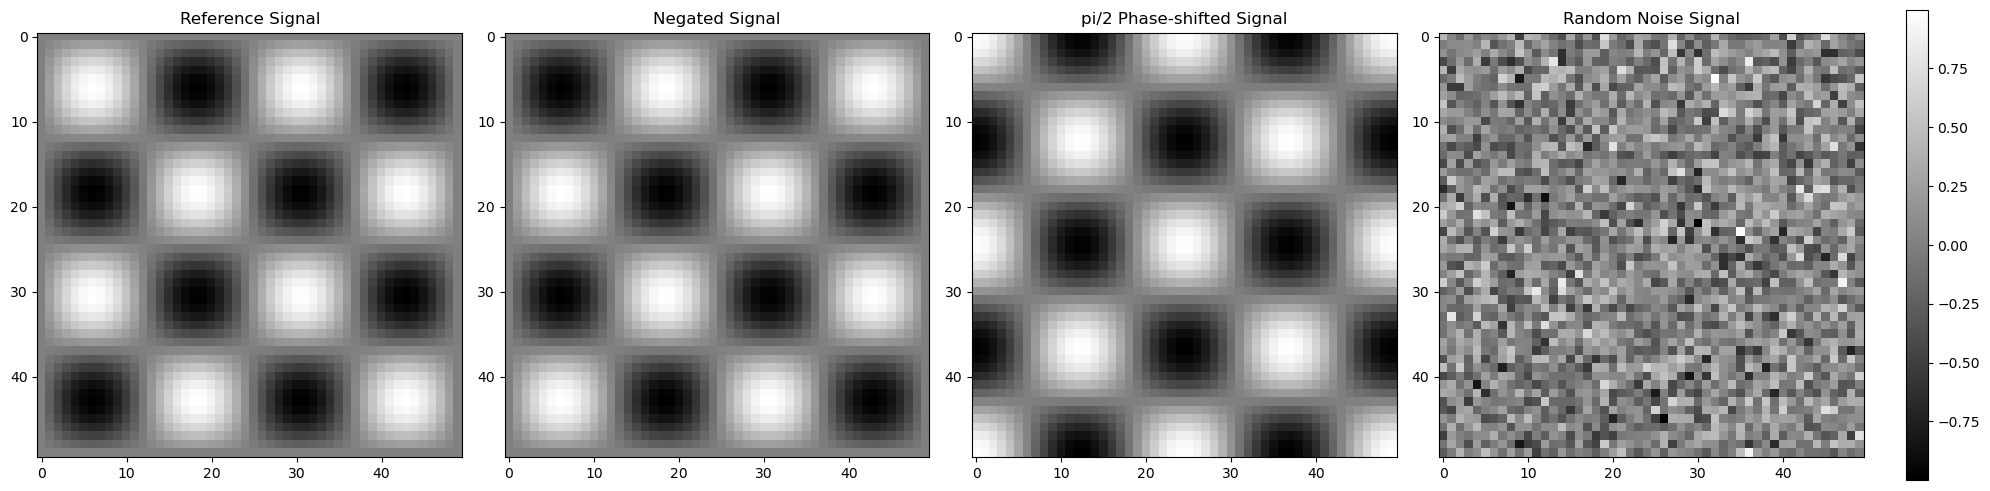

In [41]:
# Create 2D examples
def create_2d_sine(x, y, amplitude=1, frequency=1, phase=0,):
    return amplitude * np.sin(frequency*x + phase) * np.sin(frequency*y + phase)

# Create 2D grid
x_2d = np.linspace(0, 4*np.pi, 50)
y_2d = np.linspace(0, 4*np.pi, 50)
X, Y = np.meshgrid(x_2d, y_2d)

# Create different 2D test cases
reference_2d = create_2d_sine(X, Y)
test_2d_identical = reference_2d.copy()
test_2d_negated = -reference_2d
test_2d_half_shifted = create_2d_sine(X, Y, phase=np.pi/2)
test_2d_quarted_shifted = create_2d_sine(X, Y, phase=np.pi/4)
test_2d_noise = np.random.randn(50, 50)
# Create visualization
fig = plt.figure(figsize=(20, 5))

# Create a grid of subplots with space for colorbar
gs = GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.05])

# Plot reference signal
ax1 = plt.subplot(gs[0])
im1 = ax1.imshow(reference_2d, cmap='gray')
ax1.set_title('Reference Signal')

# Plot negated signal
ax2 = plt.subplot(gs[1])
im2 = ax2.imshow(test_2d_negated, cmap='gray')
ax2.set_title('Negated Signal')

# Plot shifted signal
ax3 = plt.subplot(gs[2])
im3 = ax3.imshow(test_2d_half_shifted, cmap='gray')
ax3.set_title('pi/2 Phase-shifted Signal')

# Plot noise signal
ax4 = plt.subplot(gs[3])
im4 = ax4.imshow(test_2d_noise, cmap='gray')
ax4.set_title('Random Noise Signal')

# Add shared colorbar
cax = plt.subplot(gs[4])
plt.colorbar(im1, cax=cax)

plt.tight_layout()
plt.show()


In [28]:
#Calculate SSIM values for 2D cases
ssim_2d_identical = ssim(reference_2d, test_2d_identical, data_range=2)
ssim_2d_negated = ssim(reference_2d, test_2d_negated, data_range=2) 
ssim_2d_half_shifted = ssim(reference_2d, test_2d_half_shifted, data_range=2)
ssim_2d_quarted_shifted = ssim(reference_2d, test_2d_quarted_shifted, data_range=2)
ssim_2d_noise = ssim(reference_2d, test_2d_noise, data_range=2)

print(f"SSIM for identical patterns: {ssim_2d_identical:.3f}")
print(f"SSIM for negated patterns: {ssim_2d_negated:.3f}")
print(f"SSIM for half phase shifted patterns: {ssim_2d_half_shifted:.3f}")
print(f"SSIM for quarter phase shifted patterns: {ssim_2d_quarted_shifted:.3f}")
print(f"SSIM for noise patterns: {ssim_2d_noise:.3f}")


SSIM for identical patterns: 1.000
SSIM for negated patterns: 0.900
SSIM for half phase shifted patterns: -0.184
SSIM for quarter phase shifted patterns: -0.005
SSIM for noise patterns: -0.006


## SSIM Equation
## The Structural Similarity Index (SSIM) between two images x and y is defined as:
##
## $SSIM(x,y) = \frac{[2\mu_x\mu_y + C_1][2\sigma_{xy} + C_2]}{[\mu_x^2 + \mu_y^2 + C_1][\sigma_x^2 + \sigma_y^2 + C_2]}$
##
## where:
## $\mu_x, \mu_y$ = mean intensity of x and y
## $\sigma_x, \sigma_y$ = standard deviation of x and y (calculated over a sliding NxN window, typically 11x11 pixels)
## $\sigma_{xy}$ = covariance between x and y (computed using the same sliding window, moving pixel-by-pixel across the image)
## $C_1, C_2$ = constants to avoid division by zero


In [29]:
# Calculate Pearson correlation coefficients
pearson_identical = np.corrcoef(reference_2d.flatten(), test_2d_identical.flatten())[0,1]
pearson_negated = np.corrcoef(reference_2d.flatten(), test_2d_negated.flatten())[0,1]
pearson_half_shifted = np.corrcoef(reference_2d.flatten(), test_2d_half_shifted.flatten())[0,1]
pearson_quarted_shifted = np.corrcoef(reference_2d.flatten(), test_2d_quarted_shifted.flatten())[0,1]
pearson_noise = np.corrcoef(reference_2d.flatten(), test_2d_noise.flatten())[0,1]

print(f"Pearson coefficient for identical patterns: {pearson_identical:.3f}")
print(f"Pearson coefficient for negated patterns: {pearson_negated:.3f}") 
print(f"Pearson coefficient for half phase shifted patterns: {pearson_half_shifted:.3f}")
print(f"Pearson coefficient for quarter phase shifted patterns: {pearson_quarted_shifted:.3f}")
print(f"Pearson coefficient for noise patterns: {pearson_noise:.3f}")


Pearson coefficient for identical patterns: 1.000
Pearson coefficient for negated patterns: -1.000
Pearson coefficient for half phase shifted patterns: -0.000
Pearson coefficient for quarter phase shifted patterns: 0.490
Pearson coefficient for noise patterns: -0.010


## Pearson Correlation Coefficient
## The Pearson correlation coefficient between two variables x and y is defined as:
##
## $r_{xy} = \frac{\sum_{i=1}^{n} (x_i - \mu_x)(y_i - \mu_y)}{\sqrt{\sum_{i=1}^{n} (x_i - \mu_x)^2} \sqrt{\sum_{i=1}^{n} (y_i - \mu_y)^2}}$
## 
## $r_{xy} = \frac{\sigma_{xy}}{\sigma_x \sigma_y}$
##
## where:
## $x_i, y_i$ = individual values of variables x and y
## $\mu_x, \mu_y$ = mean values of x and y
## $\sigma_x, \sigma_y$ = standard deviation of x and y, calculated over a flattened image
## $\sigma_{xy}$ = covariance between x and y, calcluated over a flattened image.


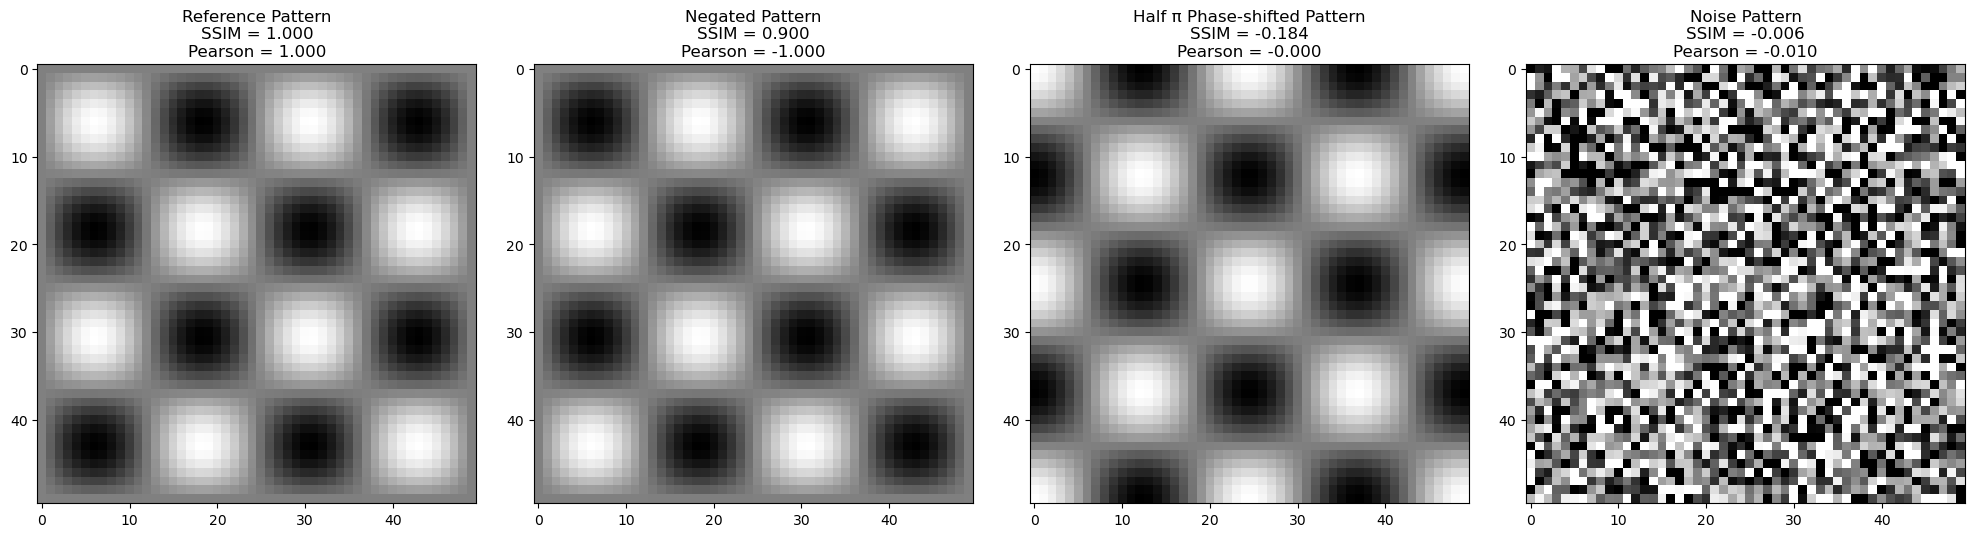

In [30]:
# Create 2D visualization
plt.figure(figsize=(20, 5))

# Plot 2D examples
plt.subplot(141)
plt.imshow(reference_2d, cmap='grey', vmin=-1, vmax=1)
plt.title('Reference Pattern\n' + 
         f'SSIM = {ssim_2d_identical:.3f}\n' +
         f'Pearson = {pearson_identical:.3f}')

plt.subplot(142)
plt.imshow(test_2d_negated, cmap='grey', vmin=-1, vmax=1)
plt.title('Negated Pattern\n' +
         f'SSIM = {ssim_2d_negated:.3f}\n' +
         f'Pearson = {pearson_negated:.3f}')

plt.subplot(143)
plt.imshow(test_2d_half_shifted, cmap='grey', vmin=-1, vmax=1)
plt.title('Half π Phase-shifted Pattern\n' +
         f'SSIM = {ssim_2d_half_shifted:.3f}\n' +
         f'Pearson = {pearson_half_shifted:.3f}')

plt.subplot(144)
plt.imshow(test_2d_noise, cmap='grey', vmin=-1, vmax=1)
plt.title('Noise Pattern\n' +
         f'SSIM = {ssim_2d_noise:.3f}\n' +
         f'Pearson = {pearson_noise:.3f}')

plt.tight_layout()


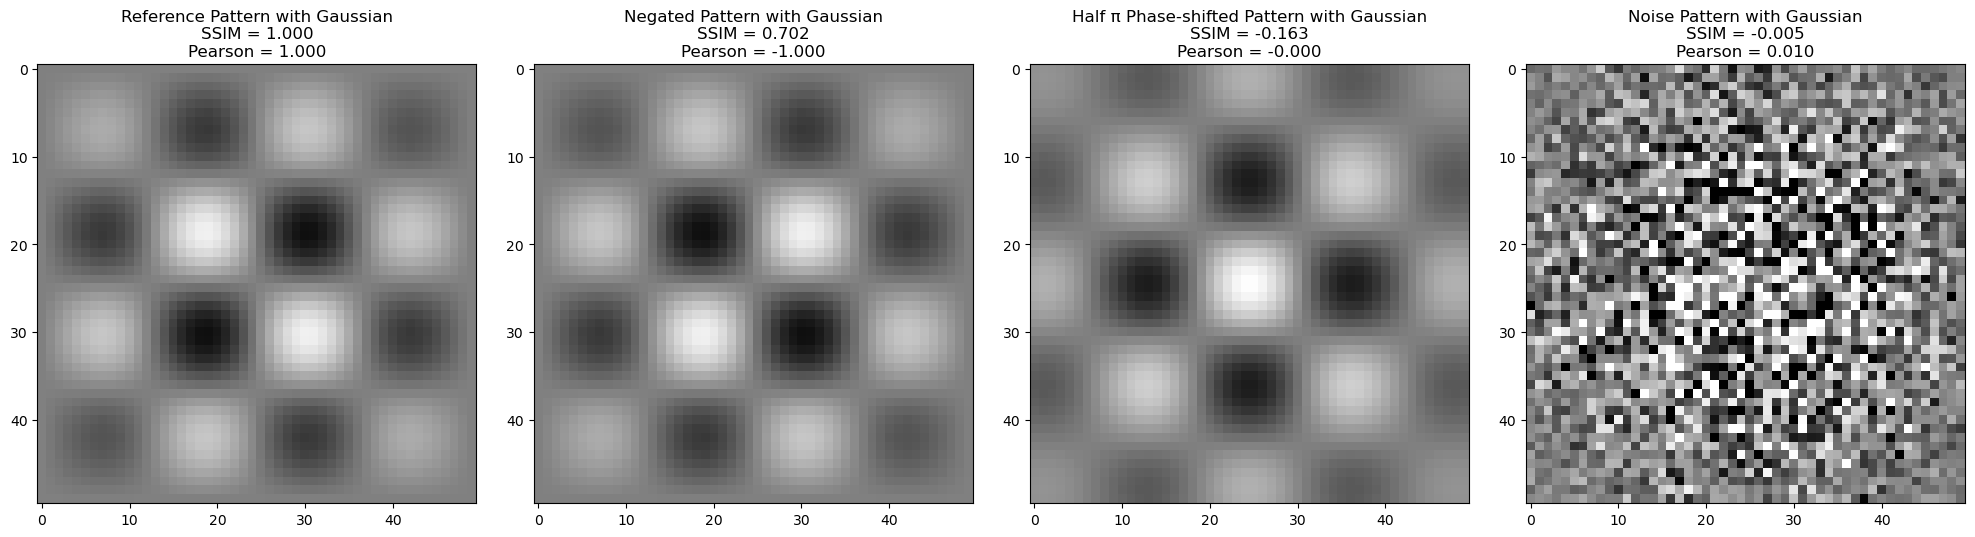

In [34]:
# Create Gaussian envelope
x = np.linspace(-1, 1, reference_2d.shape[1])
y = np.linspace(-1, 1, reference_2d.shape[0])
X, Y = np.meshgrid(x, y)
gaussian = np.exp(-(X**2 + Y**2)/1.0)  # Increased variance from 0.5 to 2.0 to make broader

# Apply Gaussian envelope to all patterns
reference_2d_gaussian = reference_2d * gaussian
test_2d_negated_gaussian = test_2d_negated * gaussian 
test_2d_half_shifted_gaussian = test_2d_half_shifted * gaussian
test_2d_noise_gaussian = test_2d_noise * gaussian

# Calculate new SSIM and Pearson values
# Add data_range parameter for floating point images
data_range = 2.0  # Range is [-1, 1] so max - min = 2
ssim_2d_identical_gaussian = ssim(reference_2d_gaussian, reference_2d_gaussian, data_range=data_range)
ssim_2d_negated_gaussian = ssim(reference_2d_gaussian, test_2d_negated_gaussian, data_range=data_range)
ssim_2d_half_shifted_gaussian = ssim(reference_2d_gaussian, test_2d_half_shifted_gaussian, data_range=data_range)
ssim_2d_noise_gaussian = ssim(reference_2d_gaussian, test_2d_noise_gaussian, data_range=data_range)

pearson_identical_gaussian = pearsonr(reference_2d_gaussian.flatten(), reference_2d_gaussian.flatten())[0]
pearson_negated_gaussian = pearsonr(reference_2d_gaussian.flatten(), test_2d_negated_gaussian.flatten())[0]
pearson_half_shifted_gaussian = pearsonr(reference_2d_gaussian.flatten(), test_2d_half_shifted_gaussian.flatten())[0]
pearson_noise_gaussian = pearsonr(reference_2d_gaussian.flatten(), test_2d_noise_gaussian.flatten())[0]

# Create 2D visualization with Gaussian envelope
plt.figure(figsize=(20, 5))

# Plot 2D examples with Gaussian envelope
plt.subplot(141)
plt.imshow(reference_2d_gaussian, cmap='grey', vmin=-1, vmax=1)
plt.title('Reference Pattern with Gaussian\n' + 
         f'SSIM = {ssim_2d_identical_gaussian:.3f}\n' +
         f'Pearson = {pearson_identical_gaussian:.3f}')

plt.subplot(142)
plt.imshow(test_2d_negated_gaussian, cmap='grey', vmin=-1, vmax=1)
plt.title('Negated Pattern with Gaussian\n' +
         f'SSIM = {ssim_2d_negated_gaussian:.3f}\n' +
         f'Pearson = {pearson_negated_gaussian:.3f}')

plt.subplot(143)
plt.imshow(test_2d_half_shifted_gaussian, cmap='grey', vmin=-1, vmax=1)
plt.title('Half π Phase-shifted Pattern with Gaussian\n' +
         f'SSIM = {ssim_2d_half_shifted_gaussian:.3f}\n' +
         f'Pearson = {pearson_half_shifted_gaussian:.3f}')

plt.subplot(144)
plt.imshow(test_2d_noise_gaussian, cmap='grey', vmin=-1, vmax=1)
plt.title('Noise Pattern with Gaussian\n' +
         f'SSIM = {ssim_2d_noise_gaussian:.3f}\n' +
         f'Pearson = {pearson_noise_gaussian:.3f}')

plt.tight_layout()


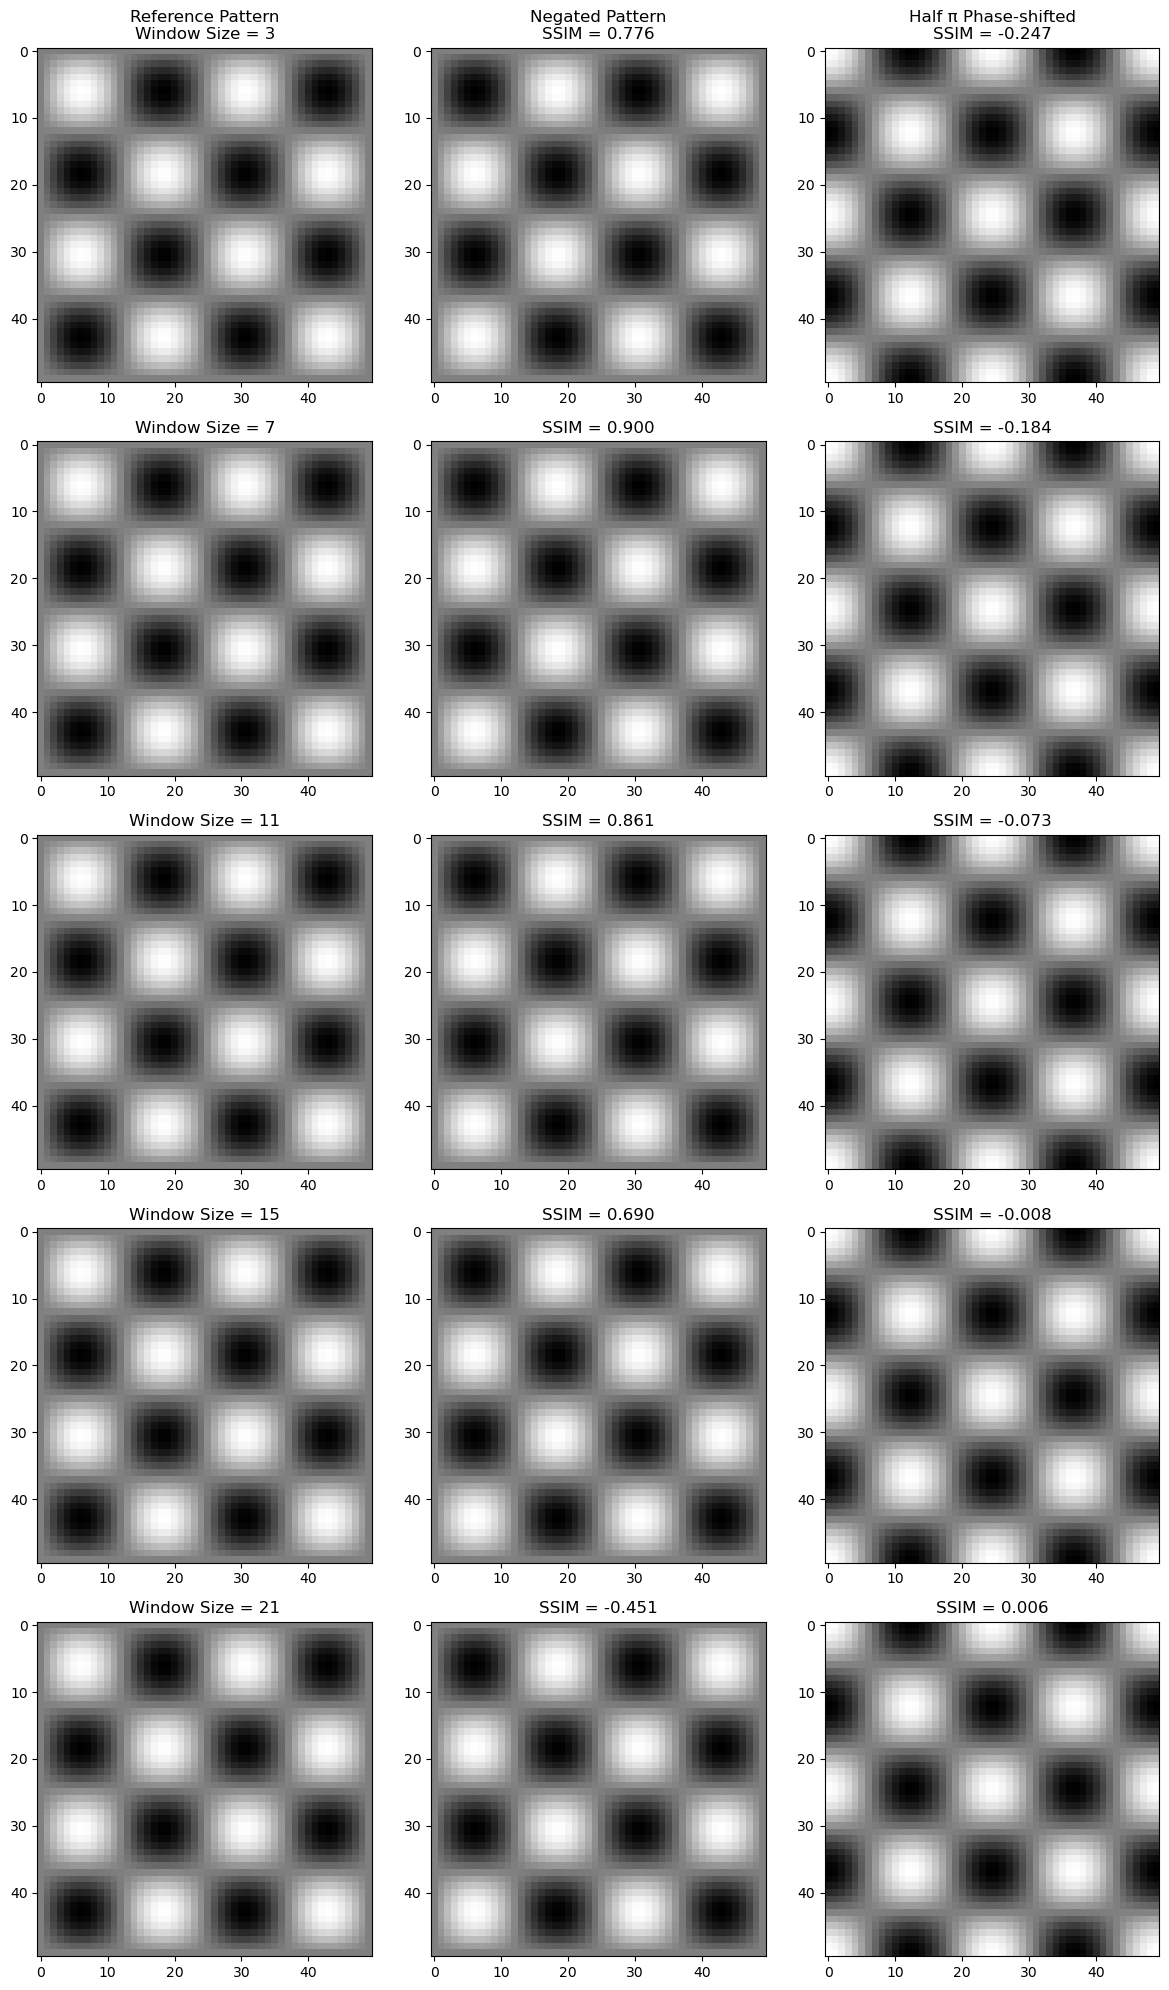

In [37]:
# Investigate window size effects on SSIM

# Test different window sizes
window_sizes = [3, 7, 11, 15, 21]
data_range = 2.0

# Calculate SSIM for different window sizes
ssim_negated = []
ssim_half_shifted = []
for win_size in window_sizes:
    ssim_neg = ssim(reference_2d, test_2d_negated, 
                    win_size=win_size, data_range=data_range)
    ssim_half = ssim(reference_2d, test_2d_half_shifted, 
                     win_size=win_size, data_range=data_range)
    ssim_negated.append(ssim_neg)
    ssim_half_shifted.append(ssim_half)

# Create visualization
plt.figure(figsize=(12, 20))

for i, win_size in enumerate(window_sizes):
    # Reference pattern
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(reference_2d, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Reference Pattern\n' + f'Window Size = {win_size}')
    else:
        plt.title(f'Window Size = {win_size}')
    
    # Negated pattern
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(test_2d_negated, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Negated Pattern\n' + f'SSIM = {ssim_negated[i]:.3f}')
    else:
        plt.title(f'SSIM = {ssim_negated[i]:.3f}')
    
    # Half-shifted pattern
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(test_2d_half_shifted, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Half π Phase-shifted\n' + f'SSIM = {ssim_half_shifted[i]:.3f}')
    else:
        plt.title(f'SSIM = {ssim_half_shifted[i]:.3f}')

plt.tight_layout()

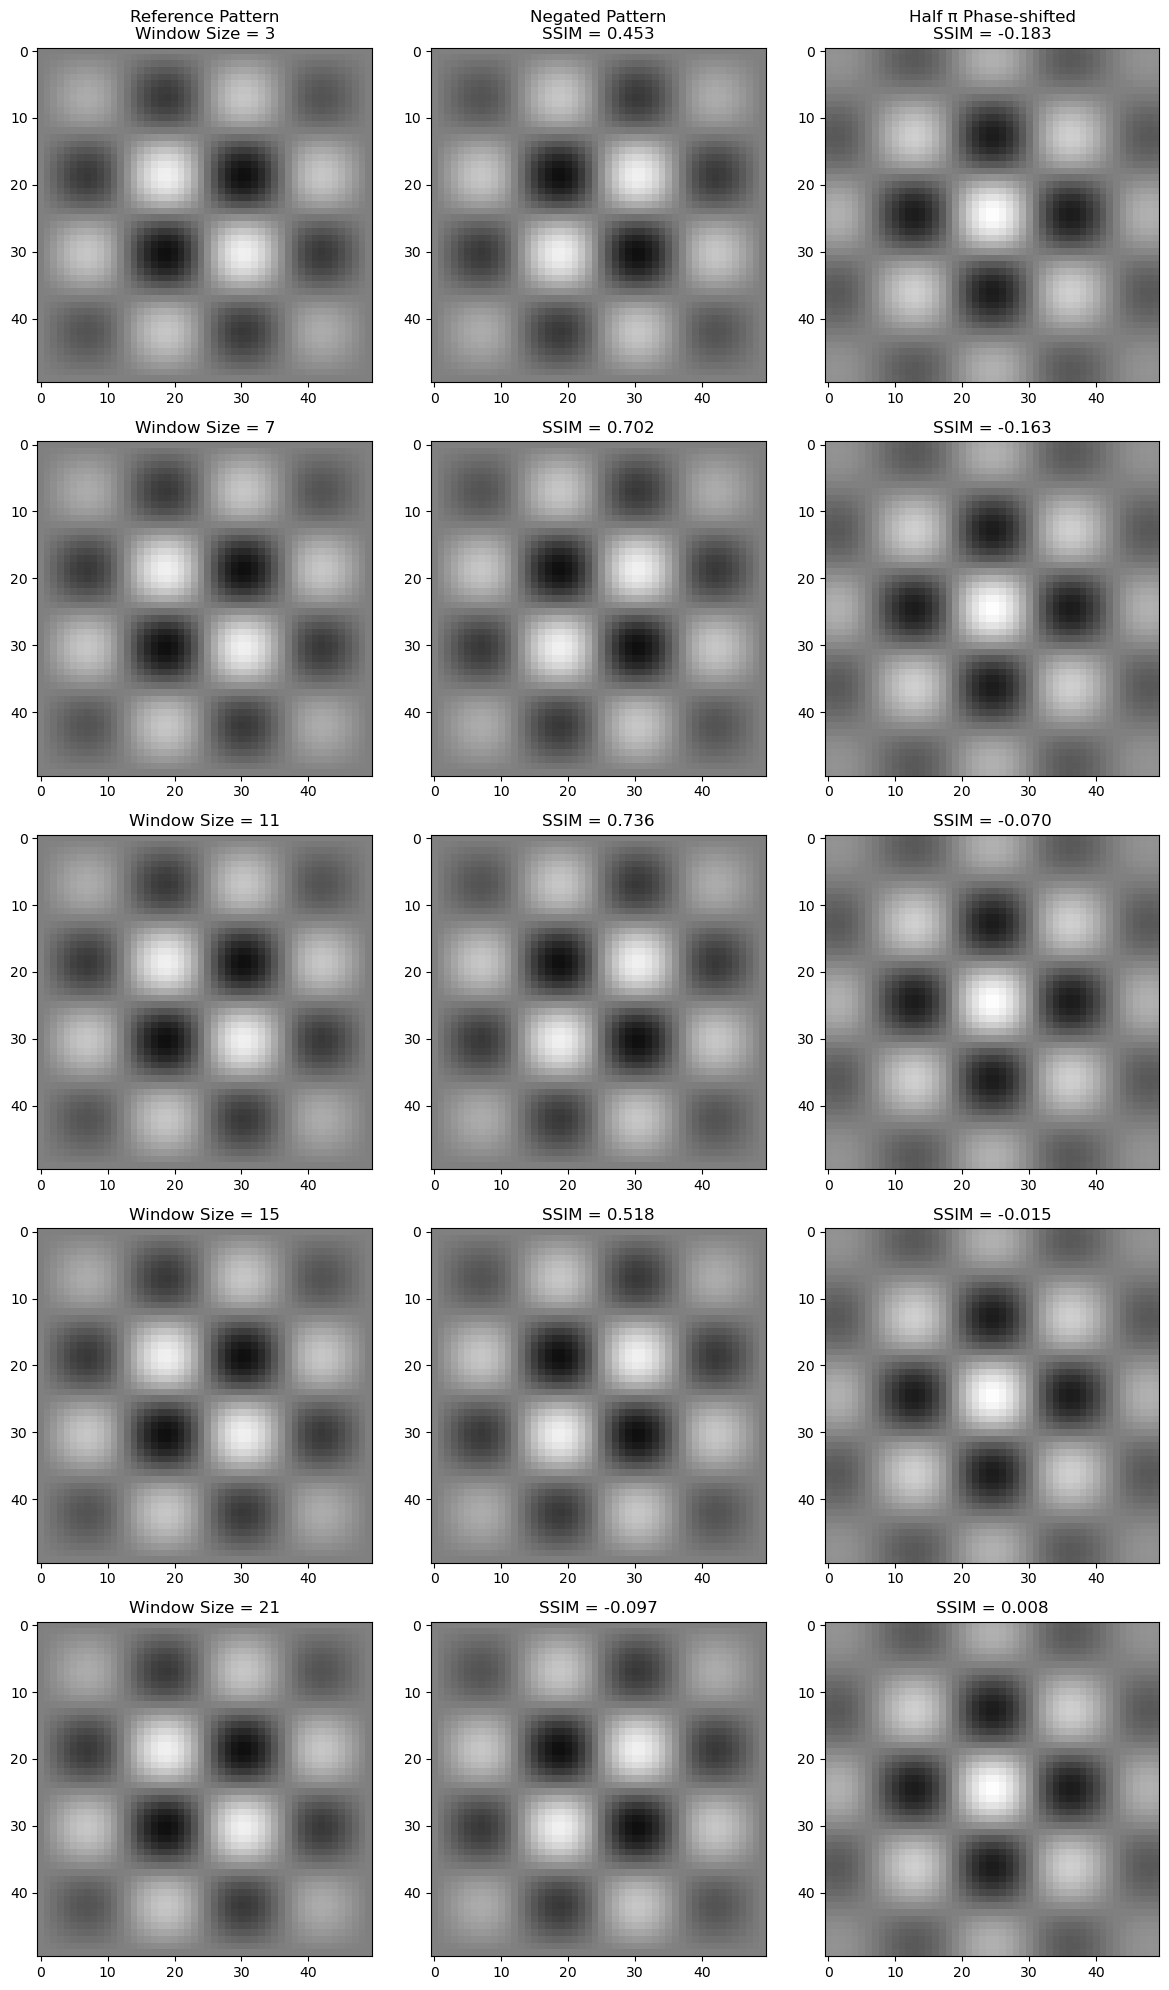

In [36]:
# Investigate window size effects on SSIM

# Test different window sizes
window_sizes = [3, 7, 11, 15, 21]
data_range = 2.0

# Calculate SSIM for different window sizes
ssim_negated = []
ssim_half_shifted = []
for win_size in window_sizes:
    ssim_neg = ssim(reference_2d_gaussian, test_2d_negated_gaussian, 
                    win_size=win_size, data_range=data_range)
    ssim_half = ssim(reference_2d_gaussian, test_2d_half_shifted_gaussian, 
                     win_size=win_size, data_range=data_range)
    ssim_negated.append(ssim_neg)
    ssim_half_shifted.append(ssim_half)

# Create visualization
plt.figure(figsize=(12, 20))

for i, win_size in enumerate(window_sizes):
    # Reference pattern
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(reference_2d_gaussian, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Reference Pattern\n' + f'Window Size = {win_size}')
    else:
        plt.title(f'Window Size = {win_size}')
    
    # Negated pattern
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(test_2d_negated_gaussian, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Negated Pattern\n' + f'SSIM = {ssim_negated[i]:.3f}')
    else:
        plt.title(f'SSIM = {ssim_negated[i]:.3f}')
    
    # Half-shifted pattern
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(test_2d_half_shifted_gaussian, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Half π Phase-shifted\n' + f'SSIM = {ssim_half_shifted[i]:.3f}')
    else:
        plt.title(f'SSIM = {ssim_half_shifted[i]:.3f}')

plt.tight_layout()


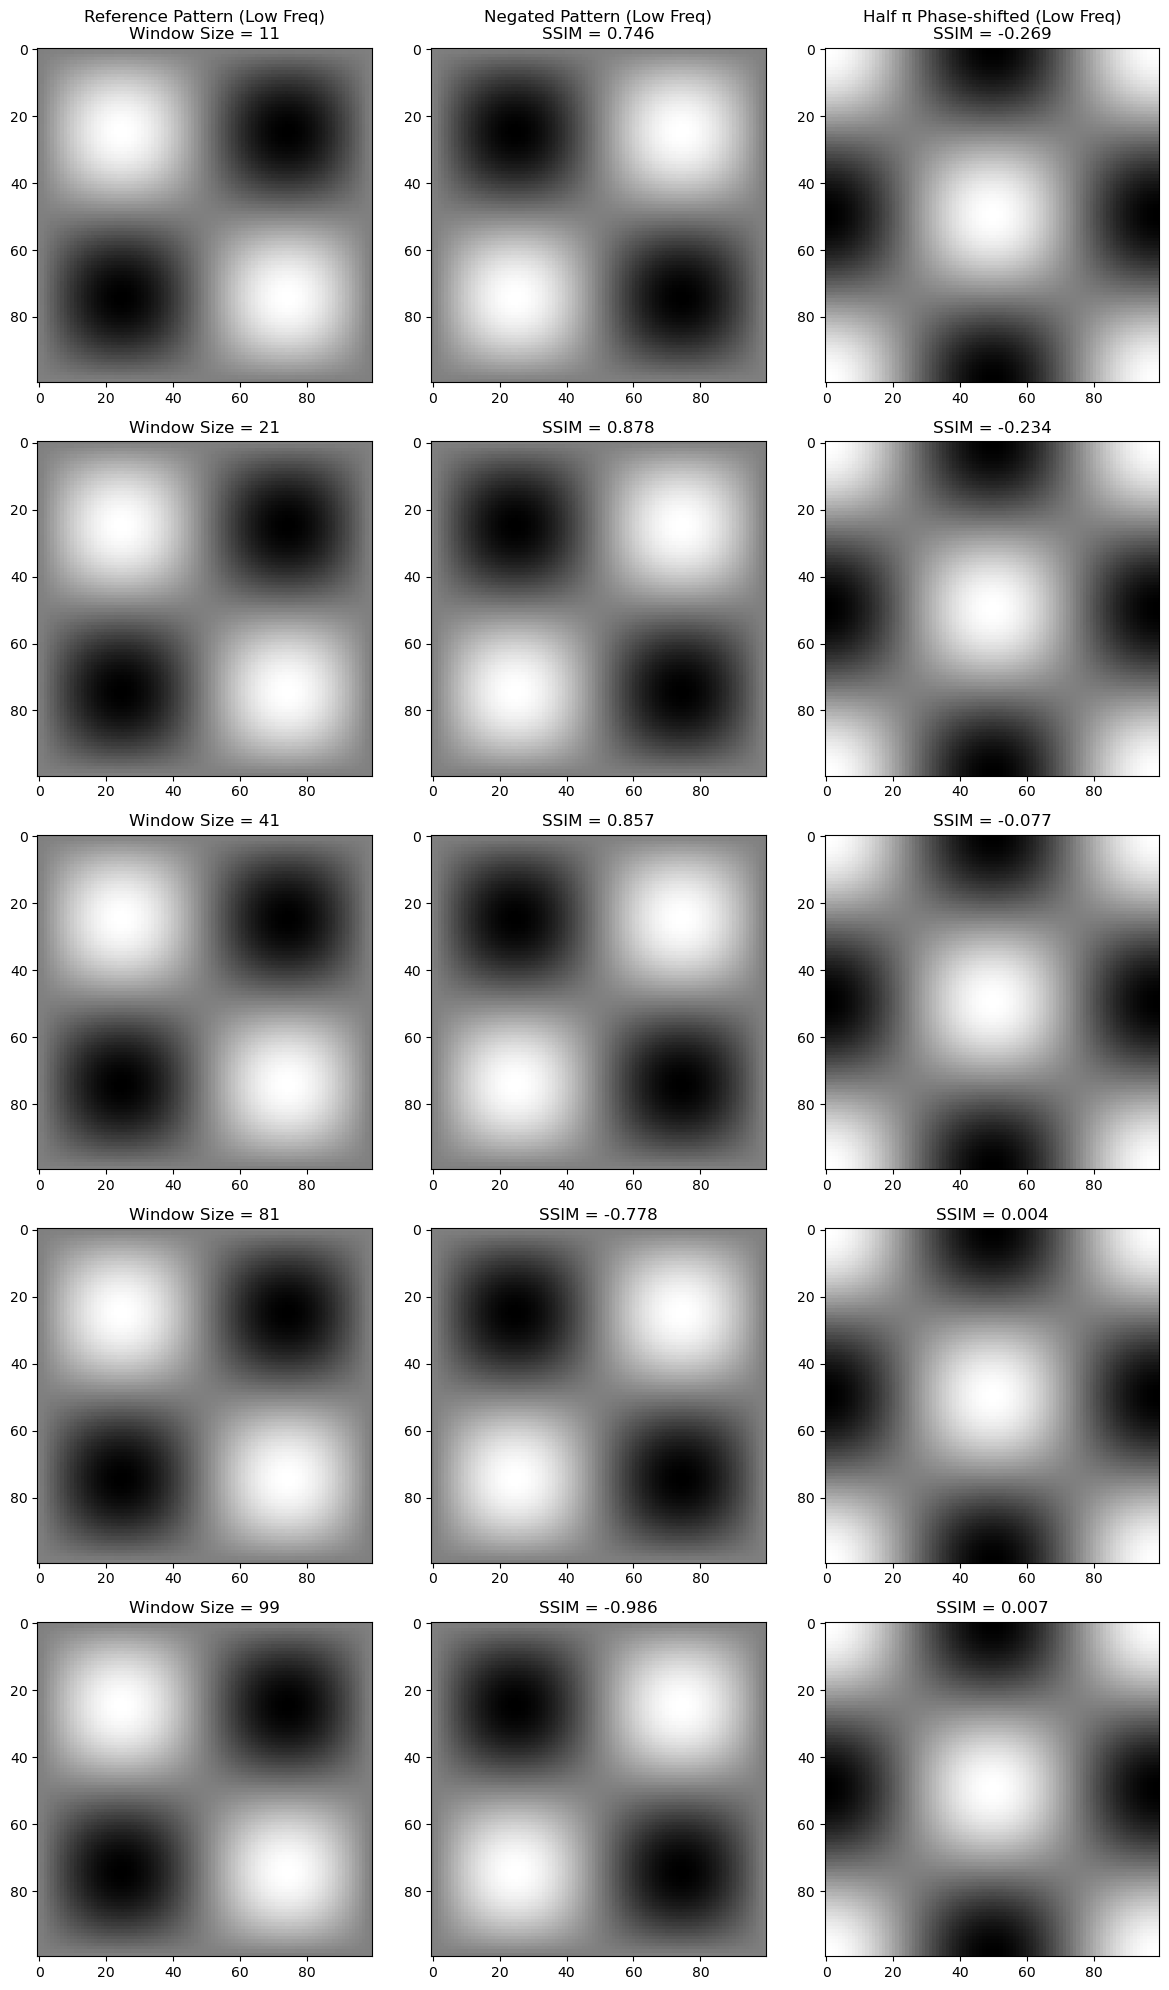

In [53]:
# Investigate the effects of different sine frequencies

# Generate sine waves with lower frequency
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Reduce frequency to 1/4
freq = 0.4 * np.pi/4  # Quarter of original frequency

# Reference pattern
reference_2d_sine_lowfreq = create_2d_sine(X, Y, amplitude=1, frequency=freq, phase=0)

# Negated pattern
test_2d_negated_sine_lowfreq = create_2d_sine(X, Y, amplitude=-1, frequency=freq, phase=0)

# Half π phase-shifted pattern
test_2d_half_shifted_sine_lowfreq = create_2d_sine(X, Y, amplitude=1, frequency=freq, phase=np.pi/2)

# Calculate SSIM for different window sizes with lower frequency patterns
ssim_negated_lowfreq = []
ssim_half_shifted_lowfreq = []
window_sizes = [11,21,41,81,99]
for win_size in window_sizes:
    ssim_neg = ssim(reference_2d_sine_lowfreq, test_2d_negated_sine_lowfreq, 
                    win_size=win_size, data_range=data_range)
    ssim_half = ssim(reference_2d_sine_lowfreq, test_2d_half_shifted_sine_lowfreq, 
                     win_size=win_size, data_range=data_range)
    ssim_negated_lowfreq.append(ssim_neg)
    ssim_half_shifted_lowfreq.append(ssim_half)

# Create visualization for lower frequency patterns
plt.figure(figsize=(12, 20))

for i, win_size in enumerate(window_sizes):
    # Reference pattern
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(reference_2d_sine_lowfreq, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Reference Pattern (Low Freq)\n' + f'Window Size = {win_size}')
    else:
        plt.title(f'Window Size = {win_size}')
    
    # Negated pattern
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(test_2d_negated_sine_lowfreq, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Negated Pattern (Low Freq)\n' + f'SSIM = {ssim_negated_lowfreq[i]:.3f}')
    else:
        plt.title(f'SSIM = {ssim_negated_lowfreq[i]:.3f}')
    
    # Half-shifted pattern
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(test_2d_half_shifted_sine_lowfreq, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Half π Phase-shifted (Low Freq)\n' + f'SSIM = {ssim_half_shifted_lowfreq[i]:.3f}')
    else:
        plt.title(f'SSIM = {ssim_half_shifted_lowfreq[i]:.3f}')

plt.tight_layout()


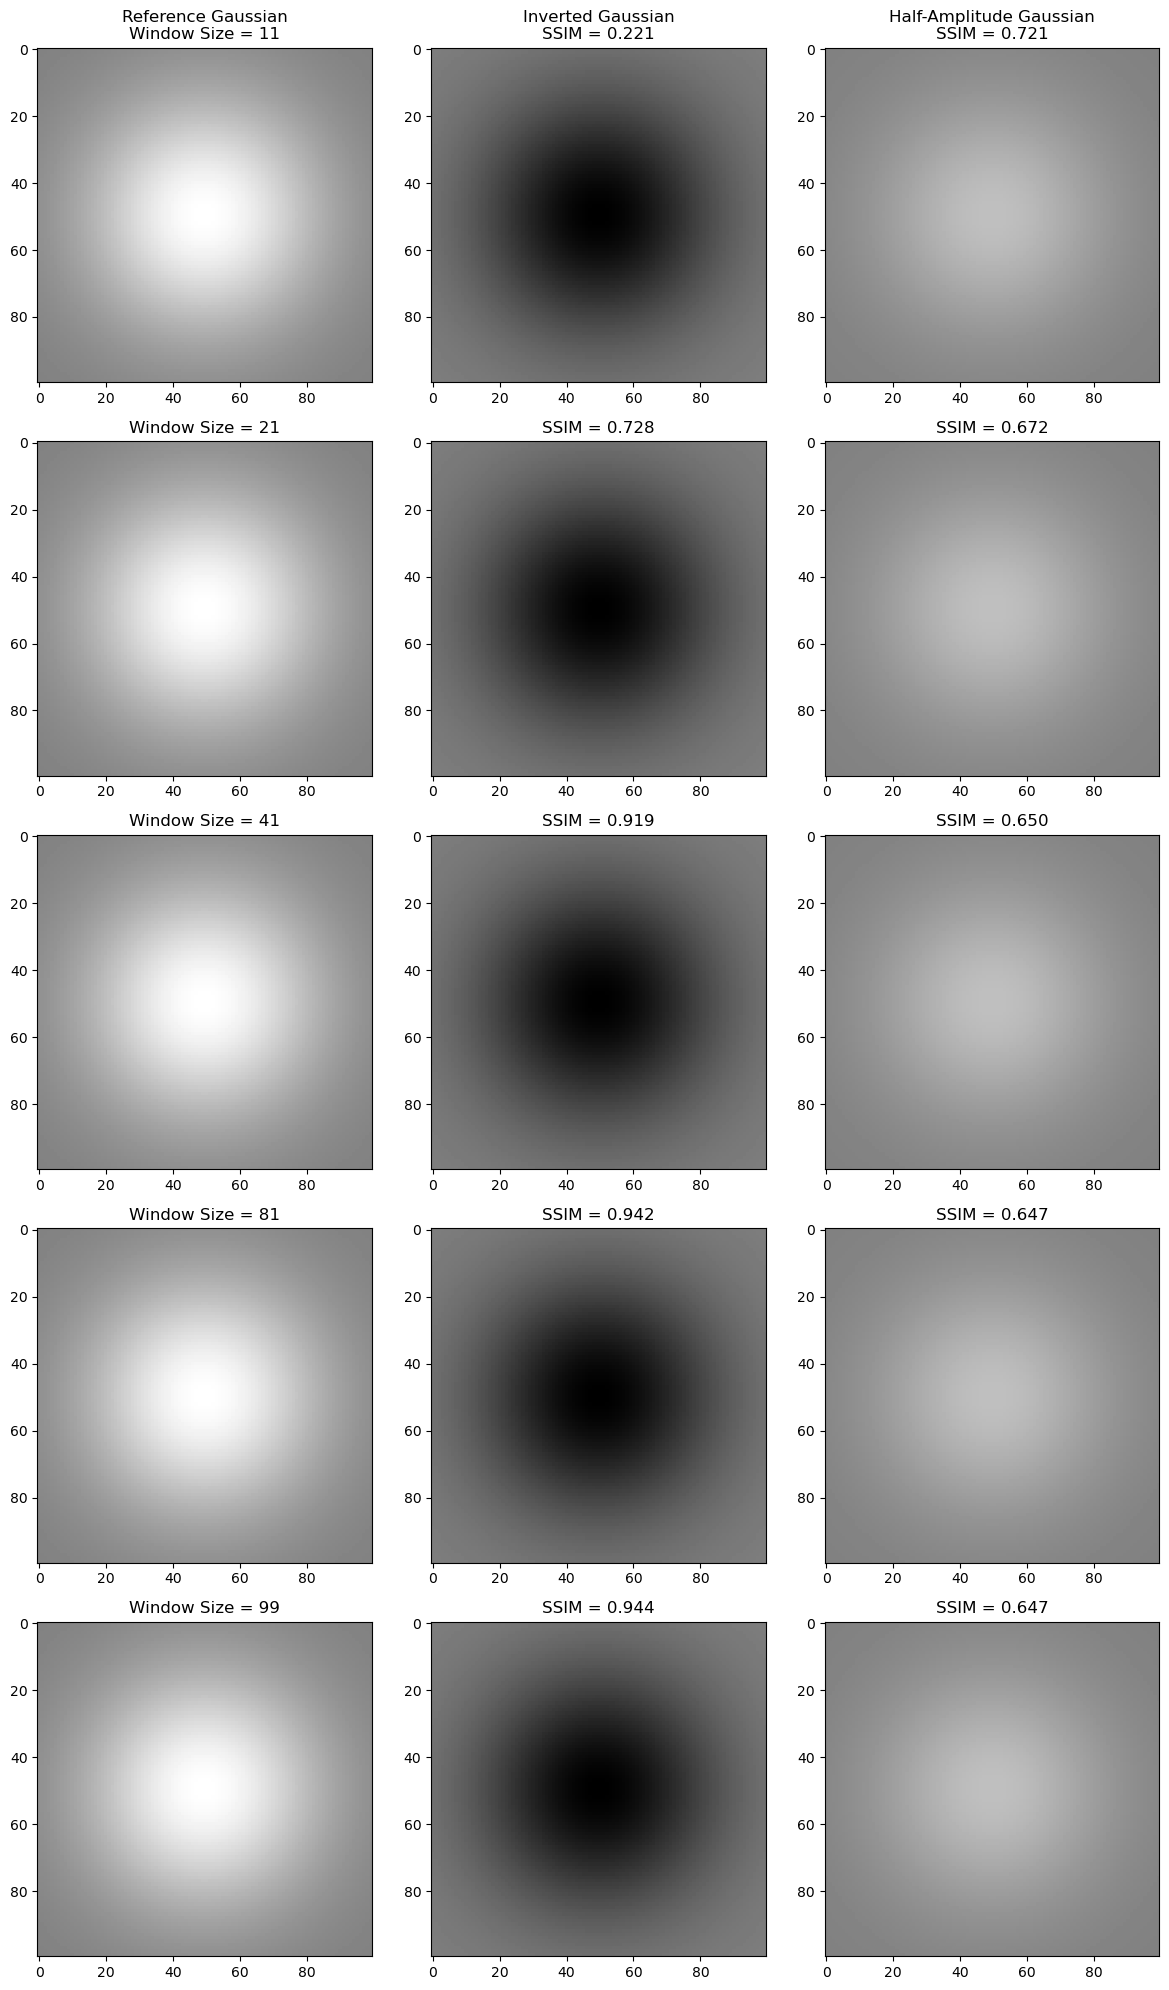

In [56]:
# Investigate the effects of different sine frequencies

# Generate sine waves with lower frequency
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Create Gaussian envelope
sigma = 5  # Width of Gaussian
R = np.sqrt(X**2 + Y**2)
gaussian = np.exp(-R**2/(2*sigma**2))

# Reference pattern (Gaussian)
reference_2d_gaussian = gaussian

# Negated pattern (inverted Gaussian)
test_2d_negated_gaussian = -gaussian

# Half amplitude pattern (scaled Gaussian)
test_2d_half_amp_gaussian = 0.5 * gaussian

# Calculate SSIM for different window sizes with Gaussian patterns
ssim_negated_gaussian = []
ssim_half_amp_gaussian = []
window_sizes = [11,21,41,81,99]
for win_size in window_sizes:
    ssim_neg = ssim(reference_2d_gaussian, test_2d_negated_gaussian, 
                    win_size=win_size, data_range=data_range)
    ssim_half = ssim(reference_2d_gaussian, test_2d_half_amp_gaussian, 
                     win_size=win_size, data_range=data_range)
    ssim_negated_gaussian.append(ssim_neg)
    ssim_half_amp_gaussian.append(ssim_half)

# Create visualization for Gaussian patterns
plt.figure(figsize=(12, 20))

for i, win_size in enumerate(window_sizes):
    # Reference pattern
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(reference_2d_gaussian, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Reference Gaussian\n' + f'Window Size = {win_size}')
    else:
        plt.title(f'Window Size = {win_size}')
    
    # Negated pattern
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(test_2d_negated_gaussian, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Inverted Gaussian\n' + f'SSIM = {ssim_negated_gaussian[i]:.3f}')
    else:
        plt.title(f'SSIM = {ssim_negated_gaussian[i]:.3f}')
    
    # Half amplitude pattern
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(test_2d_half_amp_gaussian, cmap='grey', vmin=-1, vmax=1)
    if i == 0:
        plt.title('Half-Amplitude Gaussian\n' + f'SSIM = {ssim_half_amp_gaussian[i]:.3f}')
    else:
        plt.title(f'SSIM = {ssim_half_amp_gaussian[i]:.3f}')

plt.tight_layout()

## Mathematically, for two signals $x,y$, SSIM is computed as:
##
## $SSIM(x,y) = \frac{(2\mu_x\mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$
##
## Let's set $c_1,c_2 = 0$, $SSIM(x,y) = \frac{2\mu_x\mu_y}{(\mu_x^2 + \mu_y^2)} \cdot \frac{2\sigma_{xy}}{(\sigma_x^2 + \sigma_y^2)}$
##
## Because we're working with negations, $\mu_x = -\mu_y$, so $\frac{2\mu_x\mu_y}{(\mu_x^2 + \mu_y^2)} = \frac{-\mu_x^2}{\mu_x^2}$
## In the right term, the covariance is negative for the negated image, and $\sigma_x = \sigma_y$, so
## $\frac{2\sigma_{xy}}{(\sigma_x^2 + \sigma_y^2)} = \frac{-|\sigma_{xy}|}{(\sigma_x^2)}$
## $SSIM(x,y_{negated}) = \frac{-\mu_x^2}{\mu_x^2}\cdot\frac{-|\sigma_{xy}|}{(\sigma_x^2)} = \frac{|\sigma_{xy}|}{(\sigma_x^2)}$
## Which would look identical to the case of SSIM for the original image, which is why we see SSIM ~= 1 for negated images.